<a href="https://colab.research.google.com/github/hendrikyong/CVNL_Assignment_1/blob/main/RNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download necessary NLTK data
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [15]:
# Define dataset paths from Hugging Face
splits = {
    'train': 'hf://datasets/dair-ai/emotion/split/train-00000-of-00001.parquet',
    'validation': 'hf://datasets/dair-ai/emotion/split/validation-00000-of-00001.parquet',
    'test': 'hf://datasets/dair-ai/emotion/split/test-00000-of-00001.parquet'
}

# Load datasets using pandas
train_df = pd.read_parquet(splits["train"])
val_df = pd.read_parquet(splits["validation"])
test_df = pd.read_parquet(splits["test"])

# Display dataset samples
print("Train Data Sample:\n", train_df.head())
print("Validation Data Sample:\n", val_df.head())
print("Test Data Sample:\n", test_df.head())

# Extract text and labels
train_texts, train_labels = train_df["text"].tolist(), train_df["label"].tolist()
val_texts, val_labels = val_df["text"].tolist(), val_df["label"].tolist()
test_texts, test_labels = test_df["text"].tolist(), test_df["label"].tolist()

Train Data Sample:
                                                 text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
Validation Data Sample:
                                                 text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful servant      2
3                  i am just feeling cranky and blue      3
4  i can have for a treat or if i am feeling festive      1
Test Data Sample:
                                                 text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me

In [16]:
# Tokenize all words from training set
all_words = [word for sentence in train_texts for word in word_tokenize(sentence.lower())]

# Create vocabulary mapping
word_to_idx = {word: idx + 2 for idx, word in enumerate(Counter(all_words))}
word_to_idx["<PAD>"] = 0
word_to_idx["<UNK>"] = 1  # For unknown words

# Define max sequence length
MAX_LENGTH = 30

# Convert text to sequence of tokens
def encode_text(text, word_to_idx, max_len=MAX_LENGTH):
    tokens = [word_to_idx.get(word, word_to_idx["<UNK>"]) for word in word_tokenize(text.lower())]
    return tokens[:max_len] + [word_to_idx["<PAD>"]] * (max_len - len(tokens))

# Encode datasets
train_sequences = [encode_text(text, word_to_idx) for text in train_texts]
val_sequences = [encode_text(text, word_to_idx) for text in val_texts]
test_sequences = [encode_text(text, word_to_idx) for text in test_texts]

# Convert labels to tensor
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

print("Sample encoded text:", train_sequences[0])

Sample encoded text: [2, 3, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
class EmotionDataset(Dataset):
    def __init__(self, text_sequences, labels):
        self.text_sequences = text_sequences
        self.labels = labels

    def __len__(self):
        return len(self.text_sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.text_sequences[idx]), torch.tensor(self.labels[idx])

# Create dataset instances
train_dataset = EmotionDataset(train_sequences, train_labels)
val_dataset = EmotionDataset(val_sequences, val_labels)
test_dataset = EmotionDataset(test_sequences, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Dataset Sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Dataset Sizes - Train: 16000, Val: 2000, Test: 2000


In [18]:
class EmotionLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.3):
        super(EmotionLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x_embedded = self.embedding(x)
        lstm_out, _ = self.lstm(x_embedded)
        last_hidden = lstm_out[:, -1, :]
        return self.fc(last_hidden)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionLSTM(len(word_to_idx), embed_dim=128, hidden_dim=32, num_classes=6).to(device)

print(model)

EmotionLSTM(
  (embedding): Embedding(15212, 128, padding_idx=0)
  (lstm): LSTM(128, 32, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [19]:
# Define optimizer, loss function
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-3)
criterion = nn.CrossEntropyLoss()

# Training function with validation and test accuracy evaluated only after all epochs
def train_model_with_test_eval(model, train_loader, val_loader, test_loader, optimizer, criterion, device, epochs=15):
    train_losses = []   # List to track training losses
    train_accuracies = []   # List to track training accuracies

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for texts, labels in pbar:
                texts, labels = texts.to(device), labels.to(device)
                optimizer.zero_grad()

                # Forward pass
                outputs = model(texts)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Track loss and accuracy
                train_loss += loss.item()
                train_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
                train_total += labels.size(0)

                # Update progress bar
                pbar.set_postfix(loss=f"{loss.item():.4f}")

        # Calculate training metrics
        train_loss /= len(train_loader)
        train_accuracy = (train_correct / train_total) * 100

        # Append training metrics for plotting later
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}:\n  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Return training metrics for visualization
    return train_losses, train_accuracies

    # Final Validation Step
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            val_total += labels.size(0)

    # Calculate validation metrics
    val_loss /= len(val_loader)
    val_accuracy = (val_correct / val_total) * 100
    print("\nFinal Validation Results:")
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Final Test Evaluation
    test_loss, test_correct, test_total = 0, 0, 0

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            test_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            test_total += labels.size(0)

    # Calculate test metrics
    test_loss /= len(test_loader)
    test_accuracy = (test_correct / test_total) * 100
    print("\nFinal Test Results:")
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Call the updated training function
train_losses, train_accuracies = train_model_with_test_eval(model, train_loader, val_loader, test_loader, optimizer, criterion, device, epochs=15)

Epoch 1/15:   0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-17-21e030c06cfa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.text_sequences[idx]), torch.tensor(self.labels[idx])
Epoch 1/15: 100%|██████████| 500/500 [00:04<00:00, 106.71it/s, loss=1.4811]


Epoch 1:
  Train Loss: 1.5866, Train Accuracy: 32.90%


Epoch 2/15: 100%|██████████| 500/500 [00:04<00:00, 121.03it/s, loss=1.4092]


Epoch 2:
  Train Loss: 1.5178, Train Accuracy: 34.94%


Epoch 3/15: 100%|██████████| 500/500 [00:04<00:00, 123.45it/s, loss=1.2780]


Epoch 3:
  Train Loss: 1.2802, Train Accuracy: 42.46%


Epoch 4/15: 100%|██████████| 500/500 [00:04<00:00, 107.90it/s, loss=0.8434]


Epoch 4:
  Train Loss: 1.1122, Train Accuracy: 47.29%


Epoch 5/15: 100%|██████████| 500/500 [00:04<00:00, 117.30it/s, loss=1.4000]


Epoch 5:
  Train Loss: 0.9487, Train Accuracy: 59.74%


Epoch 6/15: 100%|██████████| 500/500 [00:04<00:00, 123.86it/s, loss=0.5699]


Epoch 6:
  Train Loss: 0.6559, Train Accuracy: 78.03%


Epoch 7/15: 100%|██████████| 500/500 [00:04<00:00, 113.62it/s, loss=0.5562]


Epoch 7:
  Train Loss: 0.4694, Train Accuracy: 85.34%


Epoch 8/15: 100%|██████████| 500/500 [00:04<00:00, 115.54it/s, loss=0.2609]


Epoch 8:
  Train Loss: 0.3745, Train Accuracy: 88.67%


Epoch 9/15: 100%|██████████| 500/500 [00:04<00:00, 124.63it/s, loss=0.2167]


Epoch 9:
  Train Loss: 0.3183, Train Accuracy: 90.31%


Epoch 10/15: 100%|██████████| 500/500 [00:04<00:00, 118.69it/s, loss=0.4446]


Epoch 10:
  Train Loss: 0.2698, Train Accuracy: 91.58%


Epoch 11/15: 100%|██████████| 500/500 [00:04<00:00, 110.51it/s, loss=0.1995]


Epoch 11:
  Train Loss: 0.2215, Train Accuracy: 93.64%


Epoch 12/15: 100%|██████████| 500/500 [00:04<00:00, 123.37it/s, loss=0.2125]


Epoch 12:
  Train Loss: 0.1682, Train Accuracy: 95.05%


Epoch 13/15: 100%|██████████| 500/500 [00:04<00:00, 123.42it/s, loss=0.0136]


Epoch 13:
  Train Loss: 0.1402, Train Accuracy: 95.62%


Epoch 14/15: 100%|██████████| 500/500 [00:04<00:00, 106.04it/s, loss=0.0743]


Epoch 14:
  Train Loss: 0.1219, Train Accuracy: 96.19%


Epoch 15/15: 100%|██████████| 500/500 [00:03<00:00, 125.32it/s, loss=0.1492]

Epoch 15:
  Train Loss: 0.1055, Train Accuracy: 96.59%


In [20]:
# Evaluation function to calculate test loss, accuracy, and predictions
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    test_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    accuracy = correct / total * 100
    return avg_test_loss, accuracy, y_true, y_pred

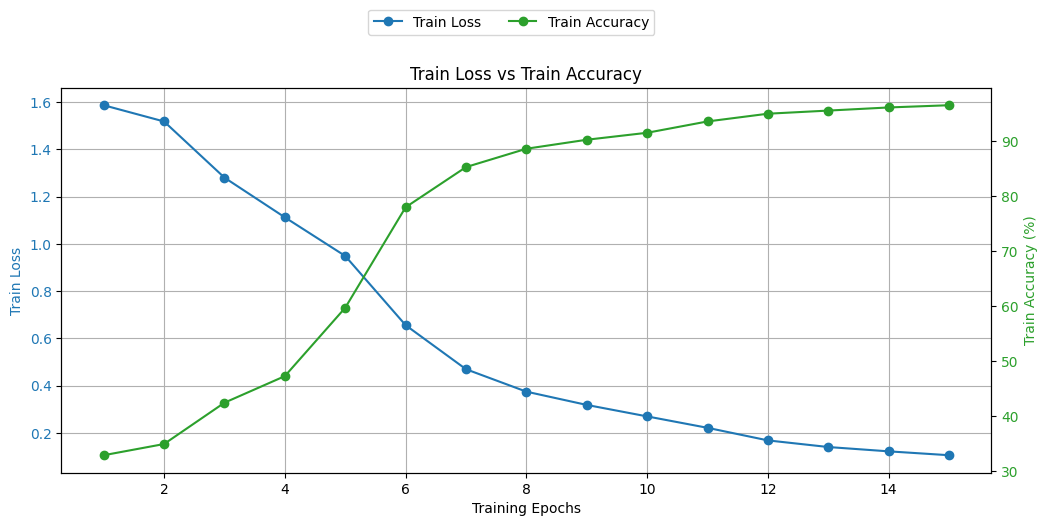

In [21]:
# Visualize Train Loss vs Train Accuracy
epochs = range(1, len(train_losses) + 1)

fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Train Loss on the first axis
ax1.set_xlabel('Training Epochs')
ax1.set_ylabel('Train Loss', color='tab:blue')
ax1.plot(epochs, train_losses, label='Train Loss', color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Train Accuracy (%)', color='tab:green')
ax2.plot(epochs, train_accuracies, label='Train Accuracy', color='tab:green', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Title and grid
plt.title('Train Loss vs Train Accuracy')
ax1.grid(True)

# Combine legends from both axes
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.show()

<ipython-input-17-21e030c06cfa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.text_sequences[idx]), torch.tensor(self.labels[idx])


Test Loss: 0.5877, Test Accuracy: 84.95%

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       581
           1       0.88      0.88      0.88       695
           2       0.61      0.67      0.64       159
           3       0.85      0.89      0.87       275
           4       0.82      0.83      0.82       224
           5       0.61      0.70      0.65        66

    accuracy                           0.85      2000
   macro avg       0.78      0.81      0.79      2000
weighted avg       0.85      0.85      0.85      2000



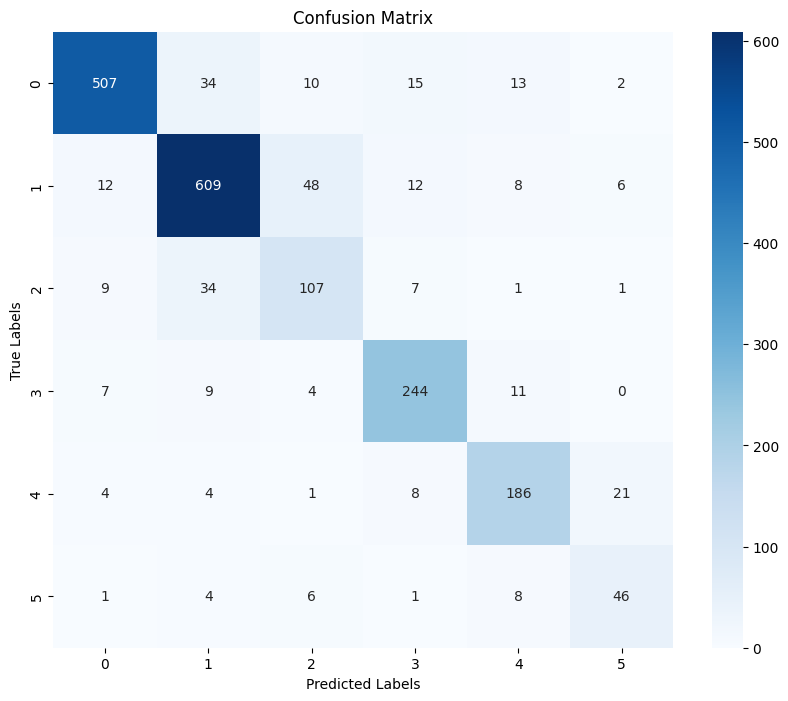

In [22]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, y_true, y_pred = evaluate_model(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(6)]))  # Replace with class names if available

# Generate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(6)], yticklabels=[str(i) for i in range(6)])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()